In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

## Importing Datasets and processing them

In [2]:
df =  pd.read_csv('/home/dileep/Desktop/python/All_csvs/source_df.csv', index_col=0)
apache = df['APACHE II Pred Mort']
trop = df['Trop Pred Mort']
df1 = df.drop(['APACHE II Pred Mort', 'Trop Pred Mort'], axis=1)

In [3]:
from data_preparation import process

# Preprocessing 
pred, targ = process(df1)
# Splitting to train set and holdout set in the proportion 85% and 15%
pred_train, pred_h, targ_train, targ_h = train_test_split(pred, targ, test_size=0.15, 
                                                          stratify=targ, random_state=64)

# NA values (where scores were not calculated or not enough data to be calcualated - scores taken as 0.
# this is done as for these scoring systems, any unavailable parameter is imputed as normal)
apache = apache.fillna(0)
trop = trop.fillna(0)

# Both apache and trop scores are split in the same way as the model set (see the same random_state variable)
ap_train, ap_h, targ_train, targ_h = train_test_split(apache, targ, test_size=0.15, 
                                                      stratify=targ, random_state=64)
trop_train, trop_h, targ_train, targ_h = train_test_split(trop, targ, test_size=0.15, 
                                                          stratify=targ, random_state=64)

# APACHE and TropICS sets are grouped into two lists of train and holdout
apache_trop = [trop_train, ap_train, targ_train]
apache_trop_h = [trop_h, ap_h, targ_h]

## Training models

In [4]:
from training_models_DU import trainModels
models = trainModels(pred_train, targ_train)

Using TensorFlow backend.


Performing model optimizations...

Estimator: Stochastic Gradient Boost
Best params: {'subsample': 0.4, 'n_estimators': 80, 'max_features': 0.8, 'max_depth': 2, 'learning_rate': 0.1}
Best training accuracy: 0.767
Test set accuracy score for best params: 0.770 

Estimator: Gradient Boost
Best params: {'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.1}
Best training accuracy: 0.753
Test set accuracy score for best params: 0.760 

Estimator: RandomForestRegressor
Best params: {'n_estimators': 60, 'min_impurity_split': 0.01, 'max_leaf_nodes': 2, 'max_depth': 8}
Best training accuracy: 0.711
Test set accuracy score for best params: 0.705 

Estimator: Logistic Regression
Best params: {'penalty': 'l1', 'C': 0.1}
Best training accuracy: 0.784
Test set accuracy score for best params: 0.788 

Estimator: XGBoost
[11:50:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:21] WARNING: src/objective/regression_obj.cu:152: reg:lin

In [4]:
# Importing models used in the paper - Skip this step if you are using own trained models
import pickle
models = []
model_names = ['sgb', 'gb', 'rf', 'lr', 'xgb', 'nn']
for idx, names in enumerate(model_names):
    filename = '/home/dileep/Desktop/python/Nature/models/{}.sav'.format(names)
    loaded_model = pickle.load(open(filename, 'rb'))
    models.append(loaded_model)

[12:55:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Evaluating models

### Discrimination - ROC Curves

In [6]:
from evaluating_models import testPerformance

In [7]:
case_train = testPerformance(pred_train, targ_train, 'train', models, apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.9160896853905973
Confidence interval for the score: [0.896 - 0.935]
Optimal threshold in training set is: 0.117
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.9068458137607074
Confidence interval for the score: [0.885 - 0.929]
Optimal threshold in training set is: 0.134
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8637212331741206
Confidence interval for the score: [0.839 - 0.888]
Optimal threshold in training set is: 0.082
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8069968025895077
Confidence interval for the score: [0.780 - 0.834]
Optimal threshold in training set is: 0.083
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.9999861840287372
Confidence interval for the score: [1.000 - 1.

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8044012785837227
Confidence interval for the score: [0.751 - 0.857]
Optimal threshold in training set is: 0.097
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.8139291861322842
Confidence interval for the score: [0.767 - 0.864]
Optimal threshold in training set is: 0.059
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7898020654044752
Confidence interval for the score: [0.739 - 0.843]
Optimal threshold in training set is: 0.107
Preparing dataset...
Evaluating...

Estimator: Logistic Regression
Score in training set: 0.8126383083353824
Confidence interval for the score: [0.759 - 0.863]
Optimal threshold in training set is: 0.07
Preparing dataset...
Evaluating...

Estimator: XGBoost
Score in training set: 0.7432382591590853
Confidence interval for the score: [0.677 - 0.8

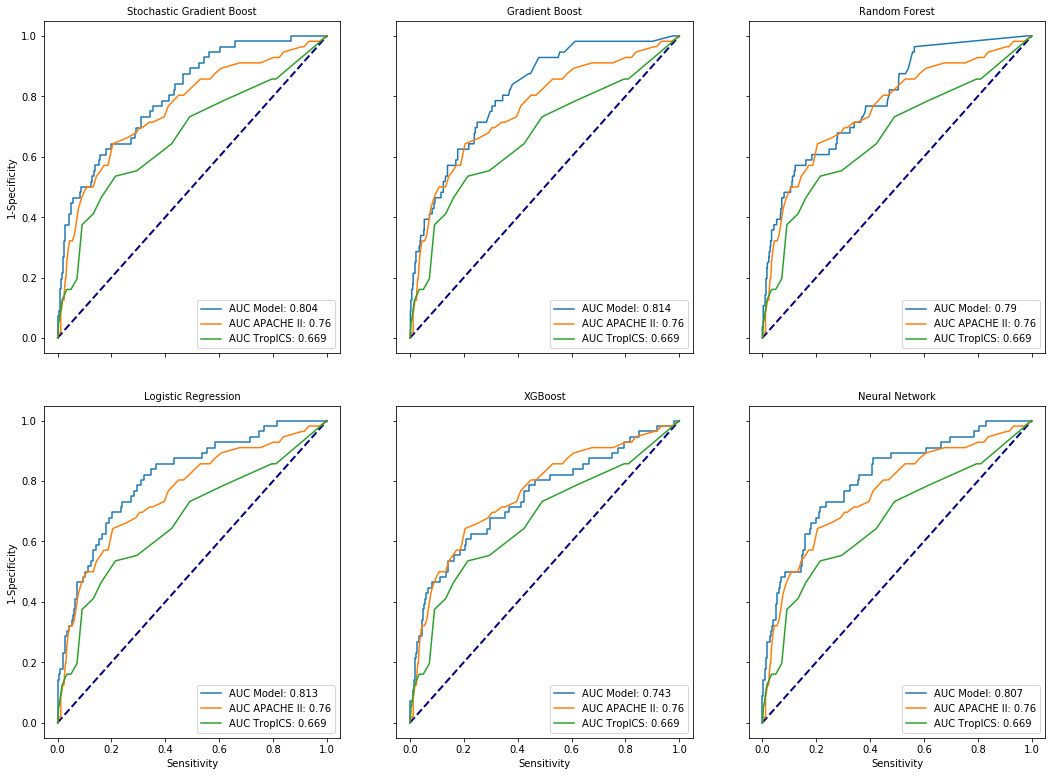

In [8]:
case_holdout = testPerformance(pred_h, targ_h, 'holdout', models, apache_trop_h)

### Calibration - Calibration plots

In [6]:
from calibration_tools import getCalibCurves

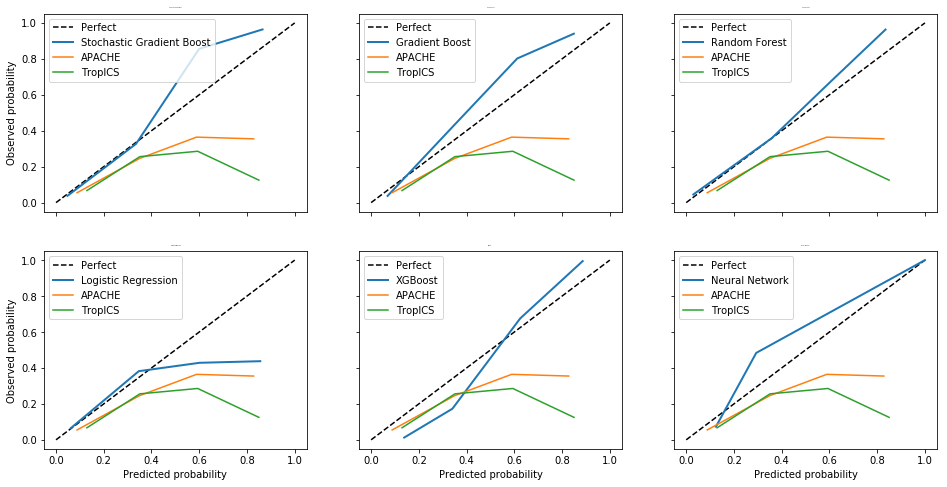

In [9]:
calib_train = getCalibCurves(pred_train, targ_train, 'train', models, apache_trop)

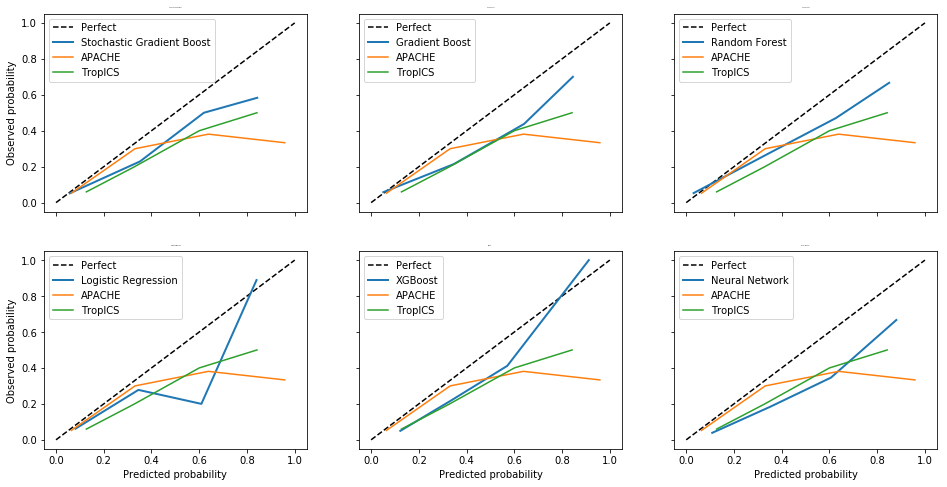

In [8]:
calib_holdout = getCalibCurves(pred_h, targ_h, 'holdout', models, apache_trop_h)